## Reproductible forecasting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.jobs import *
from jmstate.utils import *
from uniformbands import get_bands

In [2]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[..., 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

alphas = {(0, 1): torch.tensor([.4])}
betas = {(0, 1): torch.tensor([-0.9, 0.8, .2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n, 1) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c.view(-1, 1))

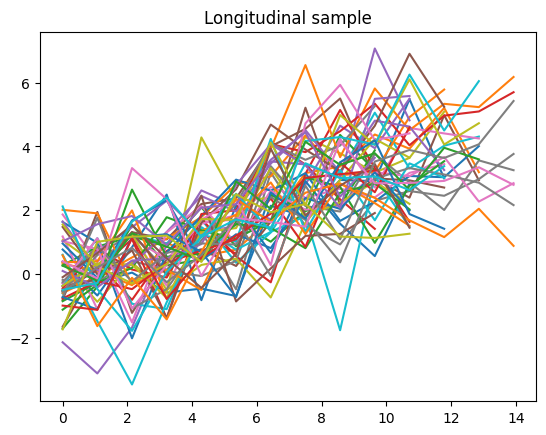

In [5]:
y = model_design.regression_fn(t, psi).squeeze(0)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

Running joint model: 100%|██████████| 1000/1000 [00:24<00:00, 40.66it/s]


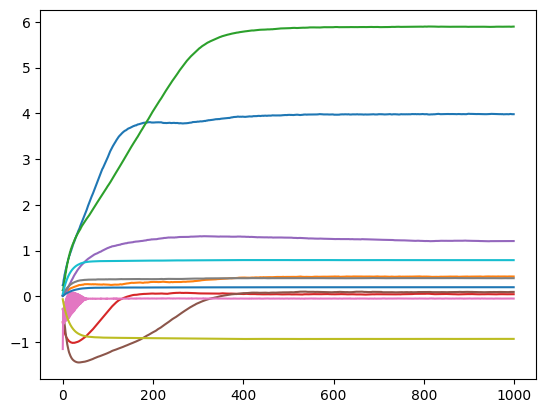

In [ ]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="full"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

model = MultiStateJointModel(model_design, init_params)

data = ModelData(
    x, t, y, trajectories, c
)

alpha = 0.4     # in (0.5, 1]
t0    = 100.0   # stabilizer
def rm_factor(step_idx: int) -> float:
    k = max(step_idx, 1)
    return (t0 / (t0 + k))**alpha


sched = Scheduling(torch.optim.lr_scheduler.LambdaLR, lr_lambda=rm_factor)

metrics = model.do(data, jobs=[RandomFit(torch.optim.SGD, lr=0.1), LogParamsHistory()], max_iterations=250)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [7]:
model.do(jobs=jmstate.jobs.ComputeFIM())
print(model.fim)
print(model.stderror)


Running joint model: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]

tensor([[ 1.6879e+03, -7.5347e+02, -6.7418e+02, -8.9447e+00,  2.8713e+01,
          7.9444e+01, -4.2611e+01,  1.0940e+02,  2.1121e+01, -4.6334e+00,
         -6.1920e+00],
        [-7.5347e+02,  1.1347e+03,  1.0529e+02, -1.7985e+01,  2.1359e+01,
          2.5798e+01, -1.1439e+02, -9.6250e+00, -1.5995e+01,  1.2546e+01,
         -3.4637e-01],
        [-6.7419e+02,  1.0529e+02,  5.7056e+02, -8.3707e+00, -2.1920e+01,
         -8.1935e+01,  3.3619e+01, -8.6252e+01, -6.1343e+00,  1.7571e+00,
          2.3977e+00],
        [-8.9447e+00, -1.7985e+01, -8.3707e+00,  4.5575e+02,  8.7007e+00,
         -1.2268e+01, -1.0490e+02,  9.8238e-01, -8.0771e-01, -1.7080e+00,
          4.8414e+00],
        [ 2.8713e+01,  2.1359e+01, -2.1920e+01,  8.7007e+00,  9.5116e+02,
          2.3696e+00, -1.7867e+02,  1.1338e+01, -3.0393e+00,  1.8634e+00,
          5.0003e+00],
        [ 7.9444e+01,  2.5798e+01, -8.1935e+01, -1.2268e+01,  2.3696e+00,
          7.7679e+02, -2.1698e+02,  2.8059e+01, -3.0859e+00, -9.2200e-0

In [8]:
n_test = 1
x_test = torch.randn(n_test, p).expand(100, p)
b_test = Q_dist.sample((n_test,))
psi_test = f(gamma, None, b_test).expand(100, 3)
trajectories_init_test = [[(0.0, 0)] for _ in range(100)]
y_test = model_design.regression_fn(t, psi_test[[0]])
y_test += R_dist.sample(y_test.shape[:-1])
y_test = y_test.expand(100, *y_test.shape[1:])

real_model = MultiStateJointModel(model_design, real_params)

for time in prediction_times:
    c_test = torch.full((100,), time).view(-1, 1)
    c_test = torch.full((100,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    real_model.do(pred_test_data, jobs=jmstate.jobs.PredictTrajectories(u[:, -1].view(-1, 1)))

NameError: name 'prediction_times' is not defined

Running joint model: 100%|██████████| 200/200 [00:02<00:00, 70.04it/s]


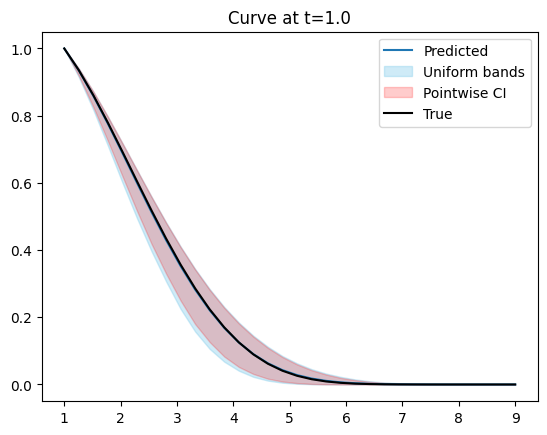

Time 1.0: Uniform coverage = 0.950, Pointwise coverage = 0.900


Running joint model:  28%|██▊       | 56/200 [00:00<00:02, 65.64it/s]


KeyboardInterrupt: 

In [ ]:
prediction_times = torch.linspace(1.0, 4.0, 4)
u_grid = torch.linspace(0, 8, 32)

logps_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time).view(-1, 1)
    sample_test_data = SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_true.append(real_model.compute_surv_logps(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_pred = real_model.do(pred_test_data, jobs=[jmstate.jobs.PredictSurvLogps(u)])
    logps_pred = torch.cat([d.unsqueeze(0) for d in logps_pred], dim=0)
    logps_pred = logps_pred.permute((1, 0, 2))

    uniform_covered_count = 0
    pointwise_covered_count = 0

    true_prob = torch.exp(logps_true[i]).numpy()
    pred_probs = torch.exp(logps_pred).numpy()

    bands = get_bands(pred_probs)
    pointwise = np.quantile(pred_probs, [0.025, 0.975], axis=1)

    uniform_covered_count += np.all((true_prob >= bands["lower"]) & (true_prob <= bands["upper"]), axis=1).mean()
    pointwise_covered_count += np.all((true_prob >= pointwise[0]) & (true_prob <= pointwise[1]), axis=1).mean()

    points = time + u_grid
    plt.plot(points, pred_probs[0].mean(axis=0), label="Predicted")
    plt.fill_between(points, bands["lower"][0], bands["upper"][0], color="skyblue", alpha=0.4, label="Uniform bands")
    plt.fill_between(points, pointwise[0, 0], pointwise[1, 0], color="red", alpha=0.2, label="Pointwise CI")
    plt.plot(points, true_prob[0], label="True", color="black")
    plt.title(f"Curve at t={time:.1f}")
    plt.legend()
    plt.show()

    uniform_coverage.append(uniform_covered_count)
    pointwise_coverage.append(pointwise_covered_count)

    print(f"Time {time:.1f}: Uniform coverage = {uniform_coverage[-1]:.3f}, Pointwise coverage = {pointwise_coverage[-1]:.3f}")

print("\nOverall coverage:")
print(f"Uniform bands: {np.mean(uniform_coverage):.3f}")
print(f"Pointwise CI: {np.mean(pointwise_coverage):.3f}")

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 174.72it/s]


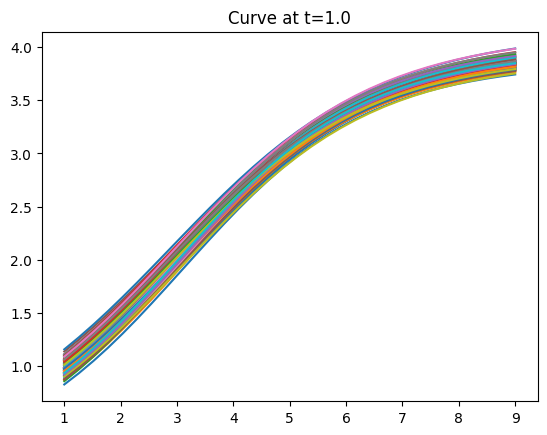

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 171.16it/s]


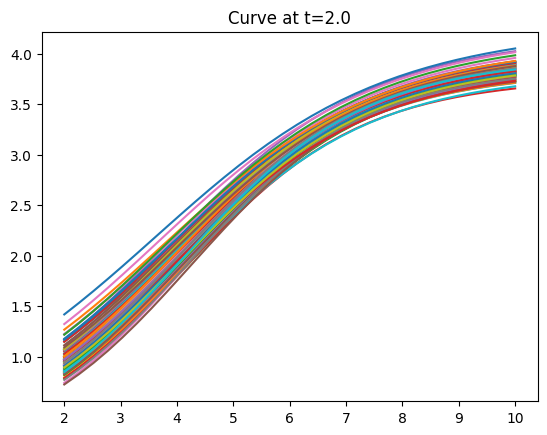

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 151.82it/s]


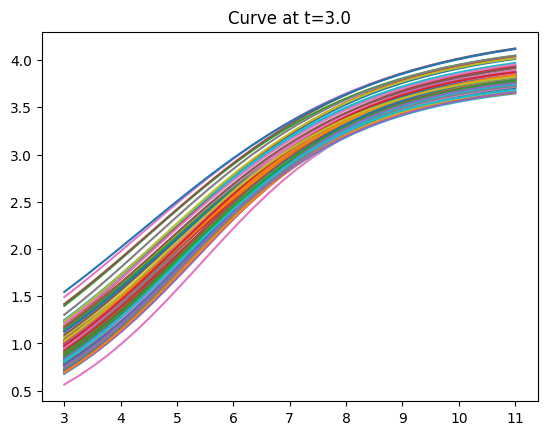

Running joint model: 100%|██████████| 200/200 [00:01<00:00, 144.70it/s]


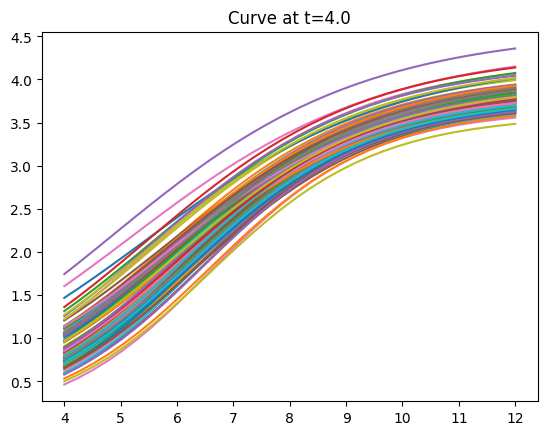

In [ ]:
for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )
    y_pr = torch.cat(real_model.do(pred_test_data, jobs=jmstate.jobs.PredictY(u)), dim=2)
    points = time + u_grid
    plt.plot(points, y_pr.mean(dim=2).T)
    plt.title(f"Curve at t={time:.1f}")
    plt.show()

In [ ]:
print(model.do(data, jobs=[jmstate.jobs.ComputeEBEs(), jmstate.jobs.ComputeCriteria()]))

Running joint model: 100%|██████████| 200/200 [00:02<00:00, 79.81it/s]

Metrics(loglik=-9842.194499999994, ebes=tensor([[-0.1281, -0.1841,  0.9348],
        [ 0.2216, -0.0834,  0.3467],
        [-0.3563,  0.0431,  0.4720],
        ...,
        [ 0.2680,  0.2696, -0.9200],
        [ 0.5027, -0.1280,  0.1321],
        [ 0.8644, -0.1280, -0.4641]]), nloglik_pen=9842.194499999994, aic=19706.38899999999, bic=19752.74969011687)
